len of df_T 175
len of df_T_forecast 100


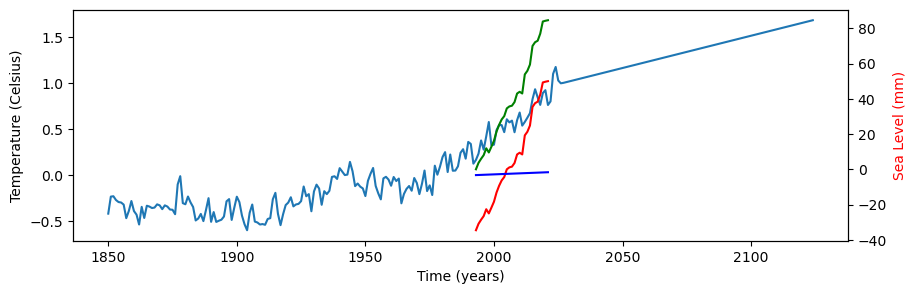

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import corner

def box_model(T, S_0, a, b, tau):
    S = np.zeros(len(T))
    S[0] = S_0
    S_eq = a * T + b
    dS = np.zeros(len(T))
    for t in range(1, len(T)):
        dS_dt = (S_eq[t-1] - S[t-1]) / tau
        S[t] = S[t-1] + dS_dt
        dS[t] = dS_dt
    return S

def four_box_model(T, S_0, a, b, tau0, tau1, tau2, tau3):
    greenland = box_model(T, S_0, a, b, tau0)
    antarctica = box_model(T, S_0, a, b, tau0)
    glaciers = box_model(T, S_0, a, b, tau0)
    thermal_expansion = box_model(T, S_0, a, b, tau0)
    return greenland + antarctica + glaciers + thermal_expansion

def load_data(base_path = '../data/', plot=False):
    # load data
    df_T_forecast = pd.read_csv(base_path + 'T_forecast_auto_arima.csv', index_col=0)
    df_T = pd.read_csv(base_path + 'processed_temperature_data.csv', index_col=0)
    df_S = pd.read_csv(base_path + 'processed_sea_level_data.csv', index_col=0)

    # stack df_T with forecast
    print('len of df_T', len(df_T))
    print('len of df_T_forecast', len(df_T_forecast))
    df_T = pd.concat([df_T, df_T_forecast])
    df_T_annual = df_T.Annual
    df_T_uncertainty = df_T.Annual_uncertainty
    df_T_annual, df_T_uncertainty

    df_S_annual = df_S.GMSL_noGIA
    df_S_uncertainty = df_S.uncertainty

    if plot:
        # now the data is ready, we will plot

        fig, ax = plt.subplots(figsize=(10, 3))
        ax2 = ax.twinx()

        ax.plot(df_T_annual, label='Temperature')
        ax2.plot(df_S_annual, label='Sea Level', color='red')

        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Temperature (Celsius)')
        ax2.set_ylabel('Sea Level (mm)', color='red')

    return df_T_annual, df_T_uncertainty, df_S_annual, df_S_uncertainty, ax2

def align_data(df_T_annual, df_T_uncertainty):
    #df_S_annual  # 1993 : 2021
    #df_T_annual  # 1850 : 2124
    T = df_T_annual.values[143:-103]
    T_unc = df_T_uncertainty.values[143:-103]

    t = df_T_annual.index[143:-103]

    return T, T_unc, t, df_T_annual.index

T_full, T_unc_full, S_obs, sigma, ax2 = load_data(plot=True)
T, T_unc, time, time_full = align_data(T_full, T_unc_full)
T_full, T_unc_full = T_full.values, T_unc_full.values
S_obs, sigma = S_obs.values, sigma.values
S_obs -= S_obs[0]

S_pred = four_box_model(T, S_0=-0.825, a=0.733, b=8.639, tau0=667.574, tau1=186.641, tau2=105.258, tau3=42.404)

ax2.plot(time, S_pred, label='Modeled Sea Level', color='blue')
ax2.plot(time, S_obs, label='Observed Sea Level', color='green')



In [80]:
time

Index([1993.0, 1994.0, 1995.0, 1996.0, 1997.0, 1998.0, 1999.0, 2000.0, 2001.0,
       2002.0, 2003.0, 2004.0, 2005.0, 2006.0, 2007.0, 2008.0, 2009.0, 2010.0,
       2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0,
       2020.0, 2021.0],
      dtype='float64')

In [81]:
T, T_unc, S_obs

(array([0.166, 0.234, 0.377, 0.277, 0.422, 0.577, 0.324, 0.331, 0.489,
        0.543, 0.544, 0.467, 0.607, 0.573, 0.592, 0.466, 0.597, 0.68 ,
        0.538, 0.578, 0.624, 0.673, 0.825, 0.933, 0.845, 0.763, 0.891,
        0.923, 0.762]),
 array([0.07134438, 0.087598  , 0.10843572, 0.08301238, 0.1083723 ,
        0.11954451, 0.09104349, 0.11271236, 0.07880474, 0.10971943,
        0.07967865, 0.1180793 , 0.04569251, 0.07797805, 0.11597422,
        0.12556038, 0.07918053, 0.11430694, 0.07084309, 0.11457045,
        0.06624256, 0.07681846, 0.11676817, 0.15377039, 0.1184118 ,
        0.0545135 , 0.09316547, 0.13517879, 0.08778841]),
 array([ 0.        ,  3.65432432,  5.95945946,  8.00901652, 11.92297297,
         9.54486486, 12.79297297, 16.18      , 21.38621622, 25.23262763,
        28.2872973 , 30.18027027, 34.57459459, 35.69707207, 36.09324324,
        38.15457207, 43.01675676, 43.99675676, 43.03513514, 53.86108108,
        55.90945946, 59.45623874, 70.02675676, 72.16513514, 72.98648649,


Running burn-in...


100%|██████████| 200/200 [00:02<00:00, 78.68it/s]


Running production...


100%|██████████| 1000/1000 [00:09<00:00, 102.37it/s]


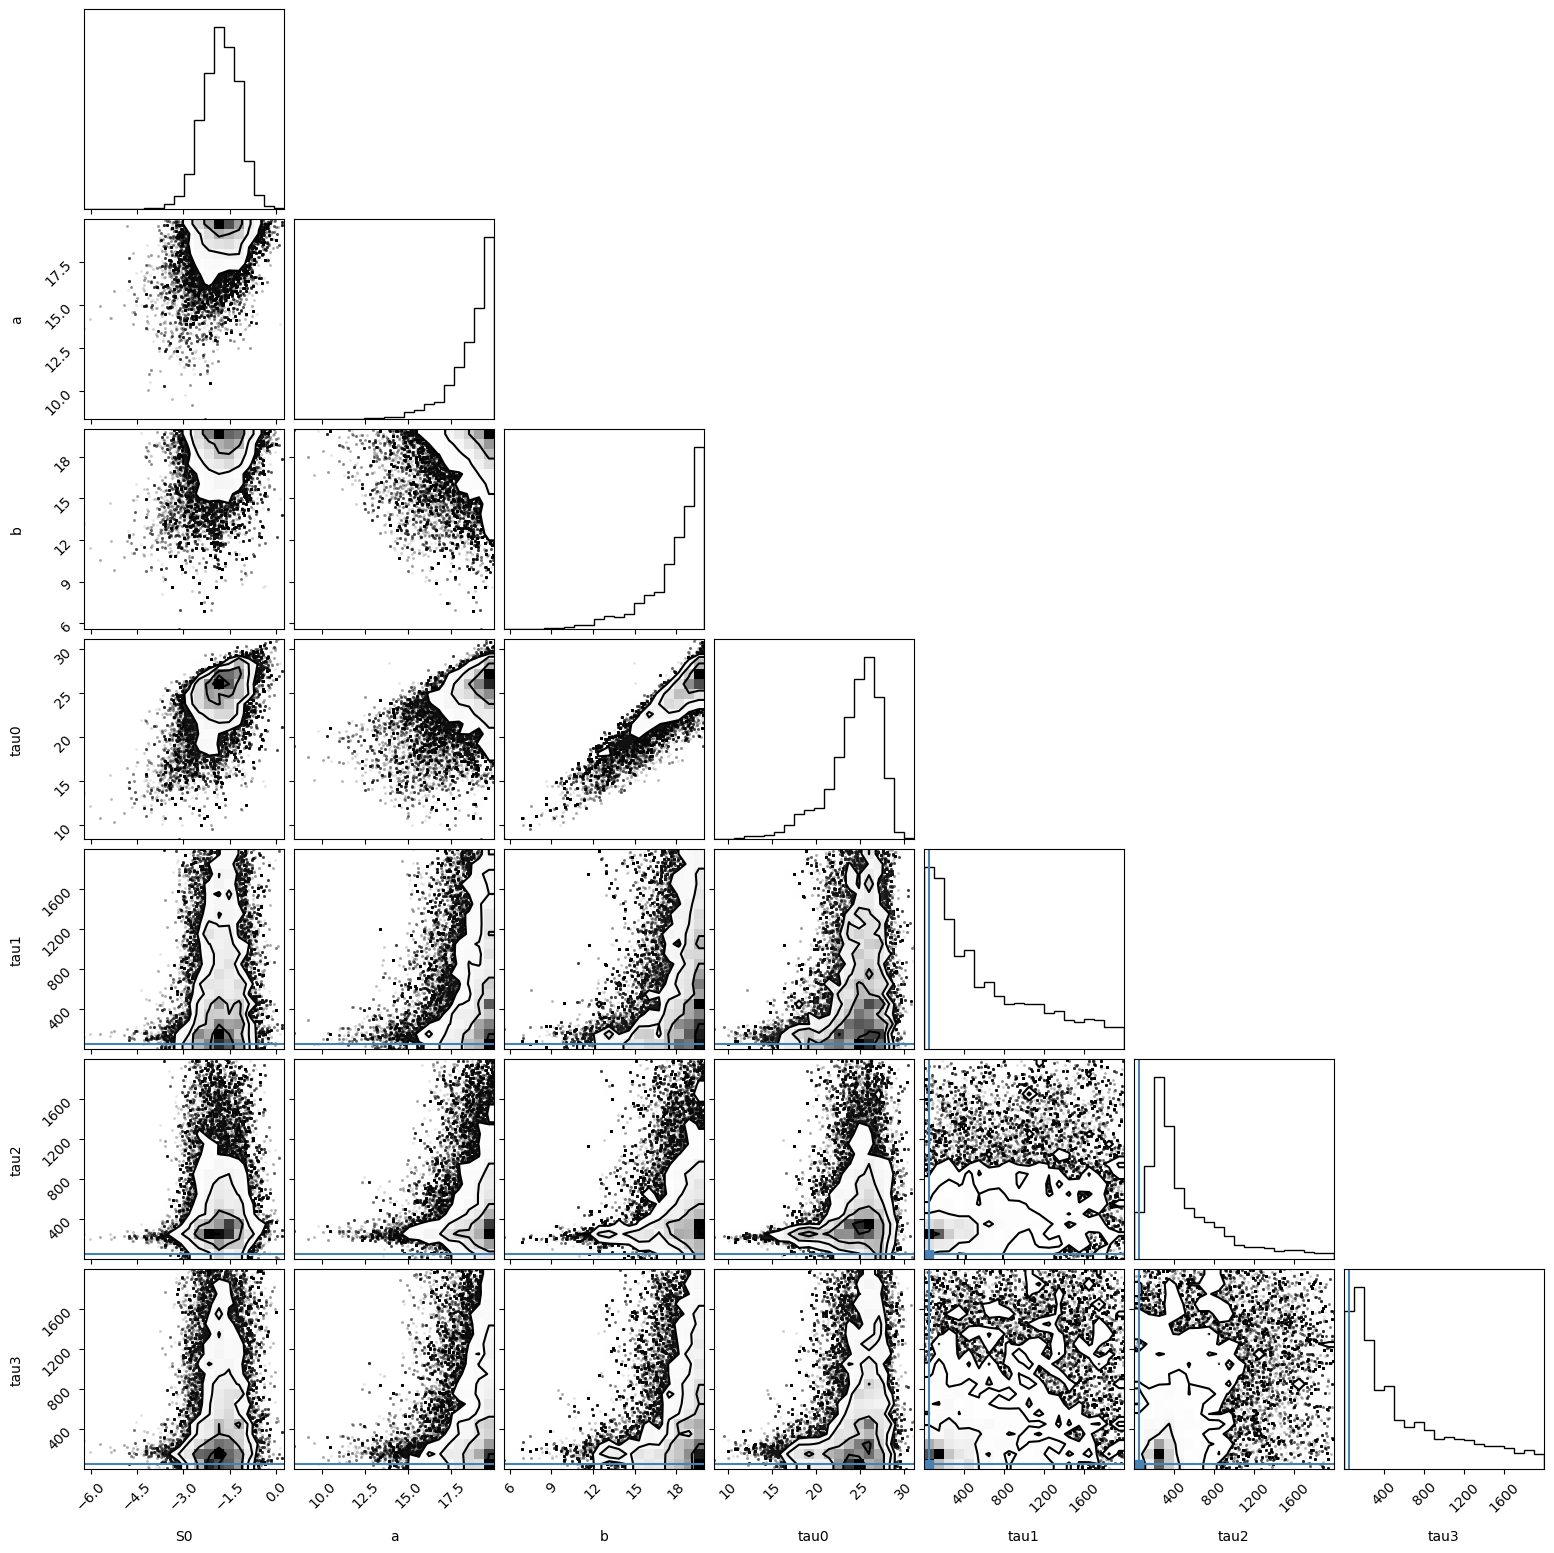

S0 = -1.765 (+0.559, -0.602)
a = 19.066 (+0.721, -1.469)
b = 18.509 (+1.123, -2.625)
tau0 = 25.050 (+1.997, -3.398)
tau1 = 462.241 (+821.094, -349.667)
tau2 = 357.929 (+499.144, -163.642)
tau3 = 378.715 (+821.405, -271.935)


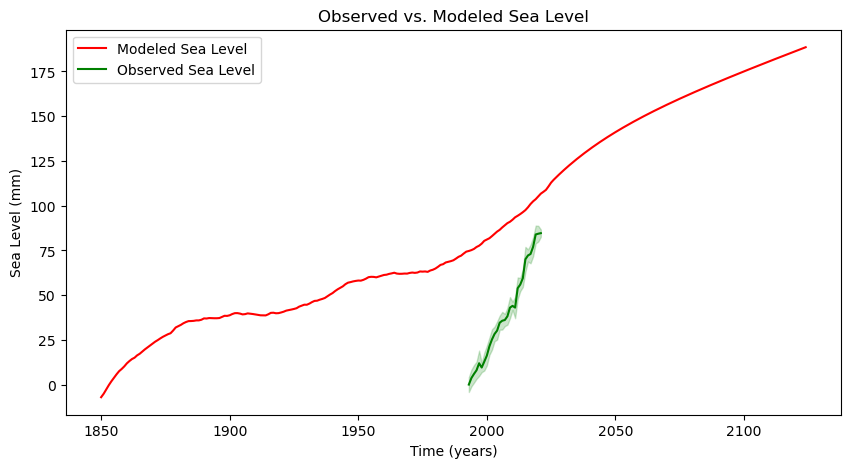

[ -1.76504345  19.0661714   18.50899122  25.04961338 462.24070726
 357.92915043 378.71535477]


In [82]:
# Assuming df_T and df_S are already provided as dataframes with relevant temperature and sea level data.

# offset = 100  # Adjust this value as needed

# Define the four-box model (assumed to be provided elsewhere)
def get_dS(T, S_0, a, b, tau0, tau1, tau2, tau3):
    return four_box_model(T, S_0, a, b, tau0, tau1, tau2, tau3)

# Define the log prior function
def log_prior_inf(theta):
    S0, a, b, tau0, tau1, tau2, tau3 = theta
    if -np.inf < S0 and S0 < np.inf and \
        -np.inf < a and a < np.inf and \
       -np.inf < b and b < np.inf and \
       -np.inf < tau0 and tau0 < np.inf and \
       -np.inf < tau1 and tau1 < np.inf and \
       -np.inf < tau2 and tau2 < np.inf and \
       -np.inf < tau3 and tau3 < np.inf:
    
        return 0.0  # Uniform prior within bounds
    return -np.inf  # Outside the bounds, log probability is negative infinity

# Define the log prior function
def log_prior(theta):
    S0, a, b, tau0, tau1, tau2, tau3 = theta
    if -500 < S0 and S0 < 500 and \
        0 < a and a < 20 and \
       0 < b and b < 20 and \
       0 < tau0 and tau0 < 2000 and \
       0 < tau1 and tau1 < 2000 and \
       0 < tau2 and tau2 < 2000 and \
       0 < tau3 and tau3 < 2000:
    
        return 0.0  # Uniform prior within bounds
    return -np.inf  # Outside the bounds, log probability is negative infinity

# Define the log likelihood function
def log_likelihood(theta, T, S_obs, sigma, T_sigma):
    S0, a, b, tau0, tau1, tau2, tau3 = theta
    
    # Sample temperature with uncertainty
    T_sampled = np.random.normal(T, T_sigma)
    
    dS = get_dS(T_sampled, S0, a, b, tau0, tau1, tau2, tau3)
    
    if np.any(np.isnan(dS)) or np.any(np.isinf(dS)):
        return -np.inf
    
    S_model = dS#np.cumsum(dS)
    
    residuals = (S_obs - S_model) / sigma
    log_likelihood_val = -0.5 * np.sum(residuals**2 + np.log(2 * np.pi * sigma**2))
    
    if np.isnan(log_likelihood_val) or np.isinf(log_likelihood_val):
        return -np.inf
    
    return log_likelihood_val

# Define the full log probability function
def log_probability(theta, T, S_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, T, S_obs, sigma, T_unc)

# Initial guess for the parameters
initial_params = [-200, .4,  .5, 40, 50, 50, 50]
ndim = len(initial_params)  # Number of parameters
nwalkers = 256  # Number of walkers for MCMC

# Initialize walkers in a Gaussian ball around the initial guess
pos = initial_params + 1e-3 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(T, S_obs, sigma))

# Burn-in phase
print("Running burn-in...")
sampler.run_mcmc(pos, 20000, progress=True)
sampler.reset()

# Production run
print("Running production...")
sampler.run_mcmc(None, 100000, progress=True)

# Extract the samples
samples = sampler.get_chain(flat=True)

# Plot posterior distributions using the corner library
fig = corner.corner(samples, labels=["S0", "a", "b", "tau0", "tau1", "tau2", "tau3"], truths=initial_params)
plt.show()

# Compute the mean and uncertainties of the parameters
param_names = ["S0", "a", "b", "tau0", "tau1", "tau2", "tau3"]
for i, name in enumerate(param_names):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{name} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")

# Use the median parameters to compute the modeled sea level
best_params = np.median(samples, axis=0)
S_model_full = get_dS(T_full, *best_params)

# Plot the observed vs. modeled sea level
plt.figure(figsize=(10, 5))
plt.plot(time_full, S_model_full, label='Modeled Sea Level', color='red')
plt.plot(time, S_obs, label='Observed Sea Level', color='green')

# Add uncertainty bounds
plt.fill_between(time, S_obs - sigma, S_obs + sigma, color='green', alpha=0.2)

plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()


popt = best_params

print(popt)

